In [1]:
import pandas as pd
import numpy as np
import glob, os, librosa, soundfile, json, h5py, logging

import librosa.display
from multiprocessing import Pool
from IPython.display import Audio
import matplotlib.pyplot as plt

from utils.util_process import *

In [2]:
mode = 'train'

params = {
    'sample_rate': 16000,
    'n_fft': 512,
    'hop_length': 160,
    'win_length': 512,
    'lower_hertz': 50,
    'upper_hertz': 8000,

    # 'sample_rate': 32000,
    # 'n_fft': 1024,
    # 'hop_length': 320,
    # 'win_length': 1024,
    # 'lower_hertz': 50,
    # 'upper_hertz': 14000,
    'mel_bins': 64
}

# data_root_path = '/media/ubuntu/ssd2t/AIGroup/Audio-Data/audioset_strong/audioset_wav_16k'
data_root_path = '/media/ubuntu/ssd2t/AIGroup/Audio-Data/audioset_strong/audioset_wav_32k'
# data_root_path = '/media/ubuntu/ssd2t/AIGroup/Audio-Data/audioset_strong/urbansound8k_wav_16k'
# data_root_path = '/media/ubuntu/ssd2t/AIGroup/Audio-Data/audioset_strong/plain_wav_16k'

np.random.seed(42)
metedata = pd.read_csv(f'{data_root_path}/{mode}.csv')
print(metedata.shape)
metedata.head(2)

(352870, 5)


,wav_id,seg_id,start_time,end_time,labels
0,Yb0RFKhbpFJA,Yb0RFKhbpFJA_0,3.95,6.05,"[52, 239, 441]"
1,Yb0RFKhbpFJA,Yb0RFKhbpFJA_1,5.95,8.05,"[52, 394, 441]"


In [3]:
# metedata = metedata[metedata['labels'].apply(lambda x: 0 in eval(x))]
metedata = metedata[metedata['labels'].apply(lambda x: 20 in eval(x))]
metedata = metedata.reset_index(drop=True)
print(metedata.shape)
metedata.head(2)

(1615, 5)


,wav_id,seg_id,start_time,end_time,labels
0,Yg_XV8FlSEn4,Yg_XV8FlSEn4_0,3.95,6.05,"[18, 20, 187]"
1,Yg_XV8FlSEn4,Yg_XV8FlSEn4_1,5.95,8.05,"[18, 20, 84, 187]"


In [4]:
random_index = np.random.randint(metedata.shape[0])
item_data = metedata.iloc[random_index, :]
wav_file = f"{data_root_path}/{mode}/{item_data['wav_id']}/{item_data['seg_id']}.wav"
# wav_file = '/media/ubuntu/ssd2t/AIGroup/Audio-Data/audioset_strong/audioset_wav_32k/train/Y80Xfe1ABYeU/Y80Xfe1ABYeU_2.wav'
print(wav_file)
(audio, _) = librosa.core.load(wav_file, sr=params['sample_rate'], mono=True)

melspec = spectrogram(data=audio,
                n_fft=params['n_fft'], 
                hop_length=params['hop_length'], 
                win_length=params['win_length'],
                window='hann',
                center=True,
                pad_mode='reflect')
logmel = logmel_spectrogram(data=melspec,
                            sr=params['sample_rate'],
                            n_fft=params['n_fft'], 
                            n_mels=params['mel_bins'],
                            fmin=params['lower_hertz'],
                            fmax=params['upper_hertz'])


/media/ubuntu/ssd2t/AIGroup/Audio-Data/audioset_strong/audioset_wav_32k/train/YEakI8v4Ztt4/YEakI8v4Ztt4_0.wav


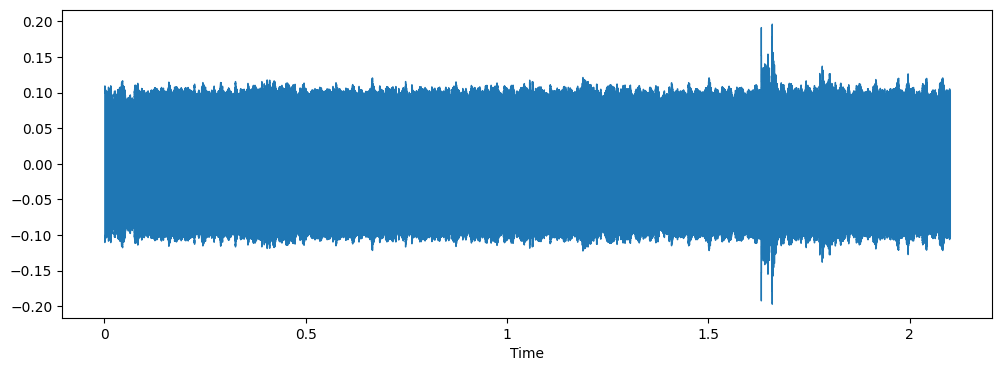

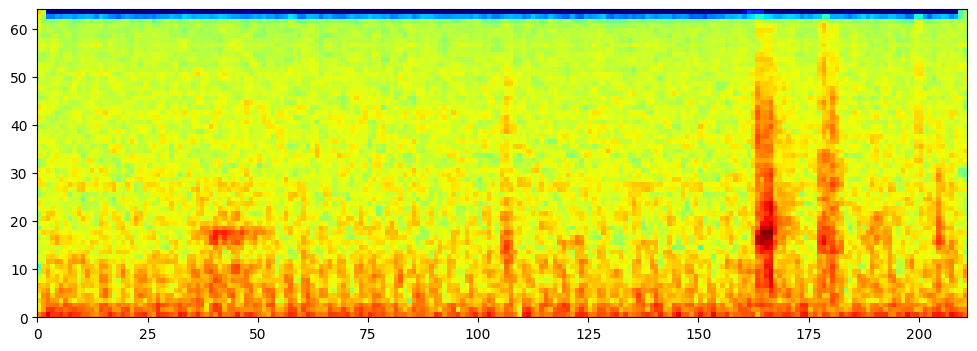

In [5]:
plt.figure(figsize=(12, 4))
librosa.display.waveshow(audio, sr=params['sample_rate'])

filter_bank = np.transpose(logmel)
plt.figure(figsize=(12, 4))
plt.imshow(np.flipud(filter_bank), 
    cmap=plt.cm.jet, 
    aspect='auto',
    extent=[0,filter_bank.shape[1], 0,filter_bank.shape[0]])

Audio(audio, rate=params['sample_rate'])

In [6]:
output_file = '/media/ubuntu/ssd2t/AIGroup/Audio-Data/audioset_strong/hdf5s/train_index_16k.h5'
with h5py.File(output_file, "r") as h5_file:
    print("H5文件中的数据集名称:", list(h5_file.keys()))
    print('audio_name', h5_file['audio_name'].shape)
    # print(h5_file["audio_name"][1])
    # print('hdf5_path', h5_file['hdf5_path'].shape)
    # print(h5_file["hdf5_path"][1])
    # print('target', h5_file['target'].shape)
    # print(h5_file["target"][1], len(h5_file["target"][1]))
    print(h5_file["audio_name"][-1])
    print('hdf5_path', h5_file['hdf5_path'].shape)
    print(h5_file["hdf5_path"][-1])
    print('target', h5_file['target'].shape)
    print(h5_file["target"][-1], len(h5_file["target"][-1]))

H5文件中的数据集名称: ['audio_name', 'hdf5_path', 'index_in_hdf5', 'target']
audio_name (354282,)
b'97392-3-0-0_0.wav'
hdf5_path (354282,)
b'/media/ubuntu/ssd2t/AIGroup/Audio-Data/audioset_strong/urbansound8k_logmel_16k/train_data.h5'
target (354282,)
[20] 1


In [7]:
output_file = '/media/ubuntu/ssd2t/AIGroup/Audio-Data/audioset_strong/urbansound8k_logmel_16k/train_data.h5'
# output_file = '/media/ubuntu/ssd2t/AIGroup/Audio-Data/audioset_strong/audioset_logmel_16k/train_data.h5'
with h5py.File(output_file, "r") as h5_file:
    print("H5文件中的数据集名称:", list(h5_file.keys()))
    print('audio_name', h5_file['audio_name'].shape)
    print(h5_file["audio_name"][-1])
    print('logmel', h5_file['logmel'].shape)
    print(h5_file["logmel"][-1])
    print('target', h5_file['target'].shape)
    print(h5_file["target"][-1])

H5文件中的数据集名称: ['audio_name', 'logmel', 'target']
audio_name (1412,)
b'97392-3-0-0_0.wav'
logmel (1412, 201, 64)
[[-66.35694  -56.85488  -49.902454 ... -62.484253 -58.640747 -61.566845]
 [-57.337765 -49.625664 -43.34491  ... -52.33969  -46.540718 -50.78137 ]
 [-55.58937  -46.585506 -40.38742  ... -38.521362 -37.637566 -45.08209 ]
 ...
 [-66.789665 -68.28935  -58.89521  ... -69.01221  -67.1975   -71.07019 ]
 [-67.014404 -62.22899  -60.291862 ... -71.48168  -69.79669  -71.15062 ]
 [-59.724274 -54.95426  -55.94536  ... -73.19493  -72.017914 -72.736435]]
target (1412, 1)
[array([20], dtype=int32)]


In [8]:
select_index = -1
output_file = '/media/ubuntu/ssd2t/AIGroup/Audio-Data/audioset_strong/urbansound8k_logmel_16k/train_data.h5'
# output_file = '/media/ubuntu/ssd2t/AIGroup/Audio-Data/audioset_strong/audioset_logmel_16k/train_data.h5'
with h5py.File(output_file, "r") as h5_file:
    print("H5文件中的数据集名称:", list(h5_file.keys()))
    print(h5_file["audio_name"][select_index])
    logmel_data = h5_file["logmel"][select_index]
    print(h5_file["target"][select_index])

wav_file = '/media/ubuntu/ssd2t/AIGroup/Audio-Data/audioset_strong/urbansound8k_wav_16k/train/97392/97392-3-0-0_0.wav'
(audio, _) = librosa.core.load(wav_file, sr=params['sample_rate'], mono=True)

melspec = spectrogram(data=audio,
                n_fft=params['n_fft'], 
                hop_length=params['hop_length'], 
                win_length=params['win_length'],
                window='hann',
                center=True,
                pad_mode='reflect')
logmel_origin = logmel_spectrogram(data=melspec,
                            sr=params['sample_rate'],
                            n_fft=params['n_fft'], 
                            n_mels=params['mel_bins'],
                            fmin=params['lower_hertz'],
                            fmax=params['upper_hertz'])


H5文件中的数据集名称: ['audio_name', 'logmel', 'target']
b'97392-3-0-0_0.wav'
[array([20], dtype=int32)]


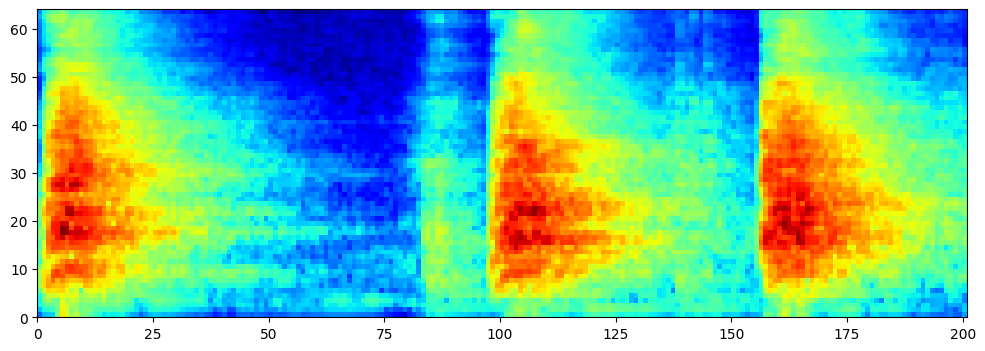

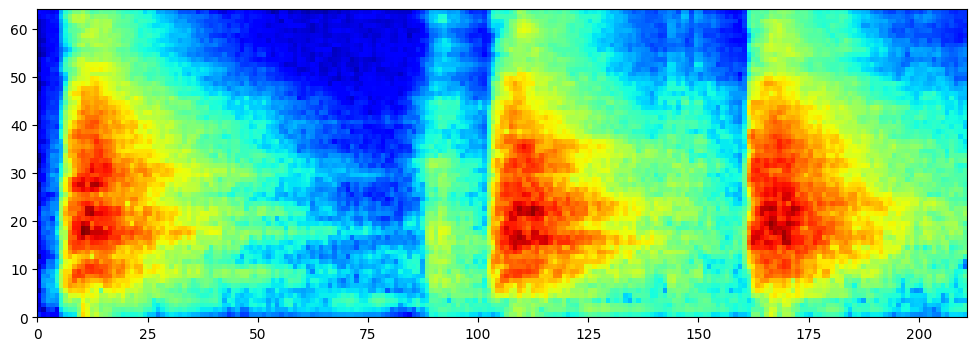

In [10]:
filter_bank = np.transpose(logmel_data)
plt.figure(figsize=(12, 4))
plt.imshow(np.flipud(filter_bank), 
    cmap=plt.cm.jet, 
    aspect='auto',
    extent=[0,filter_bank.shape[1], 0,filter_bank.shape[0]])
filter_bank = np.transpose(logmel_origin)
plt.show()

plt.figure(figsize=(12, 4))
plt.imshow(np.flipud(filter_bank), 
    cmap=plt.cm.jet, 
    aspect='auto',
    extent=[0,filter_bank.shape[1], 0,filter_bank.shape[0]])
plt.show()